In [1]:
function plot_kdist_graph(p_snnmat::SparseMatrixCSC{Float64, Int64}, k)
    kdist_arr = Float64[];

    for i in collect(1:size(p_snnmat,2))
        #Q = DataStructures.PriorityQueue(Int64, Float64, Base.Order.Reverse); # Base.Order.Reverse -> highest to lowest
        Q = DataStructures.PriorityQueue{Int64, Float64}(Base.Order.Reverse);
        nnzindices_i = p_snnmat[:,i].nzind;
        for j in nnzindices_i
            Q[j] = p_snnmat[j,i];#append similarity
        end
        c = 1;
        xx = 0;
        while c < k && length(Q) > 0 # k-th extracted item will be the k-th lowest similarity (~ k-th highest distance)
            xx = DataStructures.peek(Q)[2];
            DataStructures.dequeue!(Q);
            c += 1;
        end

        push!(kdist_arr, 1.0 - xx);
    end
    sort!(kdist_arr, rev=true); # desc order of distances 
    
    return kdist_arr
end

plot_kdist_graph (generic function with 1 method)

## DIstributed Shared Nearest Neighbor experiments

In [5]:
if length(workers()) > 1
    println("Removing previous workers...")
    rmprocs(workers())
end

addprocs(["158.251.93.5:3308","158.251.93.5:3307","158.251.93.5:3306","158.251.93.5:3305",])

#addprocs(["158.251.93.5:3308","158.251.93.5:3307","158.251.93.5:3306","158.251.93.5:3305",
#        "158.251.93.5:3304","158.251.93.5:3303","158.251.93.5:3302","158.251.93.5:3301",])

@everywhere include("/workspace/distributed_clustering/julia/src/dsnn_IO.jl")
@everywhere include("/workspace/distributed_clustering/julia/src/dsnn_KNN.jl")
@everywhere include("/workspace/distributed_clustering/julia/src/dsnn_SNN.jl")
@everywhere include("/workspace/distributed_clustering/julia/src/dsnn_Master.jl")

using PyCall
@pyimport clustering_scores as cs #clustering_scores.py must be in the path.
using JLD

Removing previous workers...


stdin: is not a tty
stdin: is not a tty
stdin: is not a tty
stdin: is not a tty


In [95]:
results = Dict{String,Any}();
DATA_PATH = "/workspace/cure_large.dat";
partitions = DSNN_Master.generate_partitions(length(workers()), 8100); # N must be extracted from the data.
overall_parameters = Dict{String, Any}("k"=>100, "snn_eps"=>0.988, "snn_minpts"=>5, "k_appindex"=>200);
DSNN_Master.start(results, DATA_PATH, partitions, 0.1, 5, worker_params=overall_parameters);

[M] Starting Stage 1 (assignment distribution and corepoint identification)
	From worker 6:	[W] executing snn clustering with eps:0.988 and minpts:5
	From worker 8:	[W] executing snn clustering with eps:0.988 and minpts:5
	From worker 7:	[W] executing snn clustering with eps:0.988 and minpts:5
	From worker 9:	[W] executing snn clustering with eps:0.988 and minpts:5
[M] Joining worker's results of Stage 1
Amount of noisy data points detected by worker 4:1969
Amount of noisy data points detected by worker 2:1956
Amount of noisy data points detected by worker 3:1981
Amount of noisy data points detected by worker 5:1959
[M] Corepoints (30) and Samples (821)
[M] Creating SNN graph with data retrieved from workers...
[M] Number of groups detected with retrieved data:503
[M] Retransmitting overall corepoints (Stage 2)...
[M] Joining Worker's results of Stage 2.
[M] Generating worker's final labelings...


The _start_ method sets the value of the dictionary _results_ by adding the following values:

* stage1_corepoints: Union of all corepoints identified by the Workers.
* stage1_sampled: Union of all the data points sampled by the Workers.
* stage1_graph: SNN Graph built with __all__ the data returned by the Workers.
* stage2_labels: Labels generated by the Workers after _stage 2_.


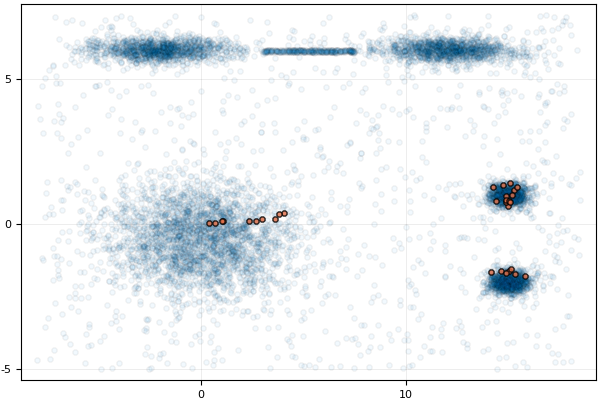

In [96]:
using Plots
pyplot()
D = DSNN_IO.sparseMatFromFile(DATA_PATH, l2normalize=false);

colors = fill(1, size(D,2));
colors[results["stage1_corepoints"]] = 2;
plt = scatter(D[1,:], D[2,:], marker=(0.05,:o,4), legend=false, fmt = :png)
scatter!(plt, D[1,results["stage1_corepoints"]], D[2,results["stage1_corepoints"]], marker=(0.8,:o,4), legend=false, fmt = :png)

In [ ]:
Stats.countmap(results["stage2_labels"])

Computing snn similarity...
SIM graph with nnz%0.0003
 12.780345 seconds (72.13 M allocations: 5.219 GiB, 8.52% gc time)
Executing snn clustering with eps:0.7 and minpts:5
  0.011436 seconds (122.27 k allocations: 8.656 MiB, 31.84% gc time)
Nr. of groups (+noise):2
Dict(2=>248,1=>7852)
Amount of noise:0.97



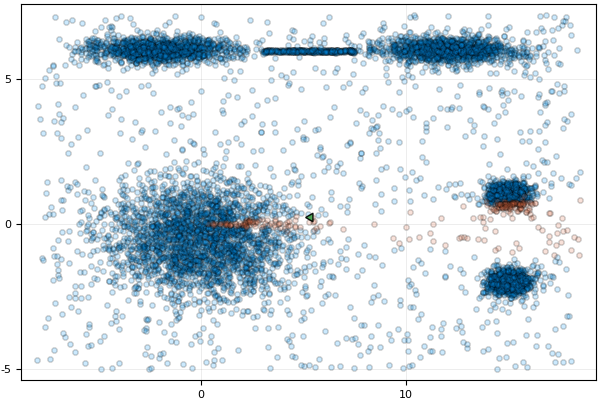

In [202]:
using Plots
pyplot()

worker_assignment = find(x -> x==11, partitions);
Dw = DSNN_IO.sparseMatFromFile(DATA_PATH, assigned_instances=worker_assignment, l2normalize=true);

@time begin
println("Computing snn similarity...")
k_ap = 100; epsilon = 0.01; k=100;
apix = DSNN_KNN.initialAppGraph(Dw, k_ap, epsilon, k_ap*2);
DSNN_KNN.improve_graph!(apix, Dw, k_ap, epsilon, k_ap*2);

knnmat_ap, nbrhd_len = DSNN_KNN.get_knnmatrix(apix, k)#, sim_threshold = 0.15);
snnmat_ap = DSNN_KNN.get_snnsimilarity(knnmat_ap, nbrhd_len)
sim_graph = DSNN_KNN.get_snngraph(knnmat_ap, snnmat_ap);

#knnmat_ap, nbrhd_len = DSNN_KNN.get_knnmatrix(apix, k, binarize=false);#, sim_threshold = 0.15);
#sim_graph = DSNN_KNN.get_knngraph(knnmat_ap);

println("SIM graph with nnz%",round(length(sim_graph.nzval)/size(sim_graph,1)^2,4))
end

@time begin
#eps=0.9500;minpts=5;
eps=0.7;minpts=5;
println("Executing snn clustering with eps:",eps," and minpts:", minpts)
results = DSNN_SNN.snn_clustering(eps, minpts, sim_graph);

labels_found = fill(0, size(results["labels"],1));
for c in collect(1:size(results["labels"],2))
    for i in results["labels"][:,c].nzind
        labels_ap[i] = results["clusters"][c]; # extract the right assigned label name
    end
end
end
# reporting results
println("Nr. of groups (+noise):",length(unique(labels_found)))
println(Stats.countmap(labels_found))
println("Amount of noise:",round(length(results["labels"][:,1].nzind)/size(results["labels"],1),2))
Dw_unnorm = DSNN_IO.sparseMatFromFile(DATA_PATH, assigned_instances=worker_assignment, l2normalize=false);
Plots.scatter(Dw_unnorm[1,:], Dw_unnorm[2,:], marker=(0.2,:o,4), groups=labels_found, legend=false, fmt = :png)
Plots.scatter!(Dw_unnorm[1,results["corepoints"]], Dw_unnorm[2,results["corepoints"]], marker=(0.9,:<,7), legend=false, fmt = :png)


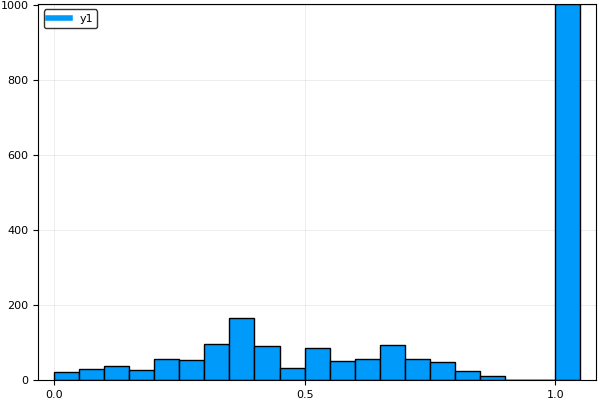

In [73]:
kdist_graph = plot_kdist_graph(snn_graph, k);
Plots.histogram(kdist_graph)

In [128]:
?DSNN_KNN.get_snngraph

```
get_snngraph(KNNMatrix, SIMMatrix)
```

KNNMatrix is a binary matrix, whose columns denote the neighbors of the object represented by the column index. Returns an adjacency matrix in which two vertices are connected only if both are in each other neighborhood. The weight of the edge that connects each pair of vertices is given by its similarity value.


In [129]:
?DSNN_KNN.get_knngraph

```
get_knngraph(KNNMatrix)
```

KNNMatrix is a __NON__ binary matrix, whose columns denote the neighbors of the object represented by the column index. Returns an adjacency matrix in which two vertices are connected only if both are in each other neighborhood. The weight of the edge that connects each pair of vertices is given by its similarity value.


In [169]:
dot(Dw[:,1], Dw[:,2])

0.8420173686127117

In [162]:
Dw[:,1]

2-element SparseVector{Float64,Int64} with 2 stored entries:
  [1]  =  0.996615
  [2]  =  0.0822043

In [168]:
Dw[:,2]

2-element SparseVector{Float64,Int64} with 2 stored entries:
  [1]  =  0.883513
  [2]  =  -0.468407

In [170]:
sqrt((Dw[1,1]-Dw[1,2])^2+(Dw[2,1]-Dw[2,2])^2)

0.5621078746776076

In [171]:
sqrt((Dw[1,1]-Dw[1,101])^2+(Dw[2,1]-Dw[2,101])^2)

0.023460756488219422

In [198]:
results["labels"][:,1]

8100-element SparseVector{Int64,Int64} with 7805 stored entries:
  [1   ]  =  1
  [2   ]  =  1
  [3   ]  =  1
  [4   ]  =  1
  [5   ]  =  1
  [6   ]  =  1
  [8   ]  =  1
  [9   ]  =  1
  [10  ]  =  1
  [11  ]  =  1
          ⋮
  [8090]  =  1
  [8091]  =  1
  [8092]  =  1
  [8093]  =  1
  [8094]  =  1
  [8095]  =  1
  [8096]  =  1
  [8097]  =  1
  [8098]  =  1
  [8099]  =  1
  [8100]  =  1